# Discussion of Machine Learning and Price Suggestion

## Our Original Idea

When this project was still in its infancy, our original plan was to create predictions of future list prices. With any prices related to housing being notorious for changing over time, it would not make sense to use a single cross section of all list prices from our original data set for predictions. So initially, we followed the guide in the textbook to perform a rolling OOS cross validation:

- The holdout sample will be the last 3 months.
- Train and evaluate many models. For each model:
    - Train a model on month 1, and predict outcomes in month 2.
    - Then train a model on months 1 and 2, and predict outcomes in month 3.
    - Then train a model on months 1 - 3, and predict outcomes in month 4.
    - Then train a model on months 1 - 4, and predict outcomes in month 5.
    - ...
    - Then train a model on months 1 - 11, and predict outcomes in month 12.
- Pick your preferred model.
- *Our final desired output was a range of predicted prices, grouped by neighborhood, for each month from 3/2024 - 3/2025*

After performing this and scoring it with r2 scores and MSE, we found that the predictions steadily got worse over time, but would stabilize in the last few months. 
- This implies that we need more data to perform accurate predictions on the holdout sample
- This also implies that time trends in the data are extremely influential

## Pivot from Prediction to Suggestion

- With the information above in mind, we decided that "predicting" list prices in the future wouldn't be that helpful
    - List prices change too much over time
    - Each host has a different idea of what is valuable to the customer
    - Each customer values different amenities and it could depend on region
- So we pivoted the project goal:
    - To find the **"intrinsic value" of an AirBnB listing**
    - This is not necessarily what current AirBnB list prices are, instead it is what they *should be*

- We used a similar format to the rolling OOS from above
- Instead of using a holdout to see how accurate our predictions are in the future, we used rolling training and testing so that we could have the best "suggestions" for each time frame of the data.
- Here's how it was performed in plain English:
    - Train the model on months 1+2, predict outcomes and test in month 3
    - Train the model on months 2+3, predict outcomes and test in month 4
    - Train the model on months 3+4, predict outcomes and test in month 5
    - ...
    - Train the model on months 10+11, predict outcomes and test in month 12
    - Save each model's unique fit and decide which models predict which time frames the best
- **Now our final desired output is the intrinsic value of an AirBnB listing, based on its most important features.

# Mechanical Description of Suggested Price Calculator

## Data Cleaning and Preparation

After doing a general clean of our data for use in the maps and graphs, we further cleaned the data to exclude outliers and listings with nonsensical variables (0 bathrooms, accommodates 0 people, etc.) so that we can create our models for price suggestions.

```python
# data cleaning for machine learning
listings.fillna(0, inplace=True)
listings = listings[listings.bedrooms > 0]
listings = listings[listings.bathrooms > 0]
listings = listings[listings.accommodates > 0]
listings = listings[listings.price > 0]
listings = listings[listings.price < 3500]
listings = listings[listings.beds > 0]
listings.reset_index(inplace=True)

listings.to_csv('../outputs/listings_clean.csv', index = False)
```

First we wanted to check what amenities are most common in our listings data.
- The following code creates a list of every amenity that is used:

```python
amenities_list = list(newListingsDF.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
```

To include input parameters for the various amenities that each listing has, we used the following code that creates a new column for each amenity-type:

```python
newListingsDF.loc[newListingsDF['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('TV'), 'tv'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('Elevator'), 'elevator'] = 1
newListingsDF.loc[newListingsDF['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
# etc...
```

To include an input parameter for the "property type" (entire unit, private room, etc.), we combined all of the least seen types into a category called "other".
- The following code is using .loc[~df] to set all categories not listed to the "other" category:

```python
newListingsDF.loc[~newListingsDF.property_type.isin(['Entire rental unit', 'Private room in rental unit','Entire condo','Private room in home','Entire serviced apartment','Entire home', 'Private room in condo', 'Private room in townhouse', 'Entire townhouse', 'Entire guest suite', 'Private room in bed and breakfast', 'Room in boutique hotel', 'Room in hotel']), 'property_type'] = 'Other'
```

Finally, to account for price changes over time, we merged the listings data frame with the calendar data frame:
```python
listings_model = pd.merge(calendar.rename(columns={"listing_id":"id"})
                          .drop(['available', 'adjusted_price', 'minimum_nights', 'maximum_nights'], axis=1),
                          newListingsDF.drop('price', axis=1), on='id', how='left')
```

Our final data that is used in suggestion analysis looks like this:
- There are 1,144,666 rows
- There are 34 Columns (30 variables)
- Index is 'id' and 'date'

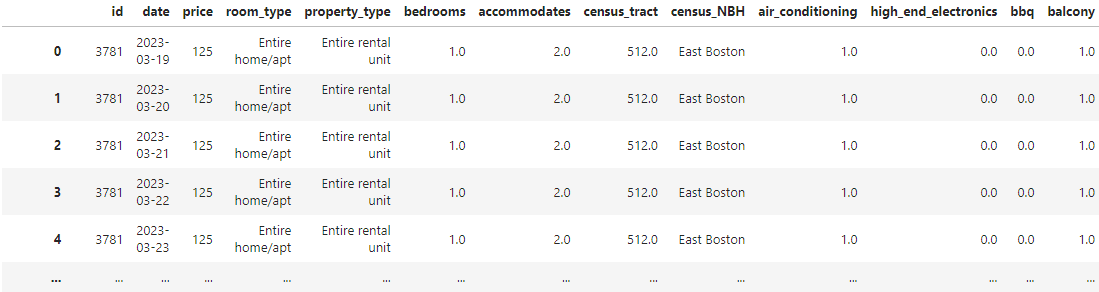

In [1]:
from PIL import Image
from IPython.display import display
img = Image.open('ML_data_picture.png')
display(img)

## Creating the Pipelines/Models

We perform two instances of rolling model training so that we can include neighborhood data in one, and census-tract data in the other.
- We split the training data into two, one for each instance:
```python
listings_model_NBH = listings_model.drop('census_tract', axis=1)
listings_model_tract = listings_model.drop('census_NBH', axis=1)
```

We constructed our pipeline using a RandomForestRegressor() to simulate the semi-random nature of influence that each variable holds in a customer's mind.
- The following code creates our pre-trained pipeline that is used when suggesting prices based on neighborhood:
```python
# create NBH pipeline
cat_pipe_features = ['room_type','property_type', 'bedrooms', 'census_NBH']
num_pipe_features = ['accommodates']
bin_pipe_features = ['air_conditioning', 'high_end_electronics', 'bbq', 'balcony', 'nature_and_views', 'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly', 'parking', 'outdoor_space', 'host_greeting', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed', 'private_entrance', 'secure', 'self_check_in', 'smoking_allowed']
cat_pipe = make_pipeline(OneHotEncoder(sparse_output=False))
num_pipe = make_pipeline(StandardScaler())
binary_pipe = make_pipeline('passthrough')

preproc_pipe = make_column_transformer(
    (cat_pipe, cat_pipe_features),
    (num_pipe, num_pipe_features),
    (binary_pipe, bin_pipe_features))

pipe_NBH = Pipeline([('columntransformer', preproc_pipe),
                 ('regression', RandomForestRegressor())])
```

- This pipeline construction is identical to the model we used for census tracts. The only difference is the inclusion of 'census_tract' instead of 'census_NBH' in the following line of code:
```python
cat_pipe_features = ['room_type','property_type', 'bedrooms', 'census_tract']
```

## Rolling Model Training

Finally we are ready to create models that will suggest an intrinsic value.
- First step is to create a dictionary that will store each model, I create it outside of the for loop:
```python
models_NBH = {}
```
- Next step is to loop through the data and train the models, here's how it's done:
```python
# Iterate over range of months
for i in range(0, 10):
    
    # re-initialize pipeline to store unique fits
    pipe_NBH = Pipeline([('columntransformer', preproc_pipe),
                 ('regression', RandomForestRegressor())])
    
    # Select rows for training set and prediction set
    train_set = listings_model_NBH.loc[(listings_model_NBH['date'] < listings_model_NBH['date'].min() + pd.DateOffset(months=i + 2)) & 
                        (listings_model_NBH['date'] >= listings_model_NBH['date'].min() + pd.DateOffset(months=i))]
    pred_set = listings_model_NBH.loc[(listings_model_NBH['date'] < listings_model_NBH['date'].min() + pd.DateOffset(months=i + 3)) & 
                        (listings_model_NBH['date'] >= listings_model_NBH['date'].min() + pd.DateOffset(months=i + 2))]
    
    # create train and test sets
    X_train = train_set.drop(['id', 'date', 'price'], axis=1)
    y_train = train_set['price']
    X_pred = pred_set.drop(['id', 'date', 'price'], axis=1)
    y_pred = pred_set['price']

    # Train pipe and store model
    pipe_NBH.fit(X_train, y_train)
    models_NBH[f"model_{i}"] = pipe_NBH
```

- Finally we ensure we are getting the desired results by including the following code inside of the for loop:
```python
    # Make predictions and evaluate performance in sample
    y_pred_hat = pipe_NBH.predict(X_pred)
    mse = mean_squared_error(y_pred, y_pred_hat)
    r2 = r2_score(y_pred, y_pred_hat)
    print('In-Sample Scores:')
    print(f'Model {i} MSE: {mse}')
    print(f'Model {i} r2: {r2}')
    print("===================================")
```

**These were our results from running all 20 models:**

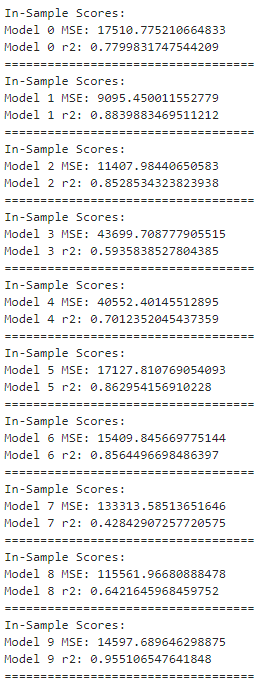

In [3]:
##################################################
# Results from training models using neighborhoods
##################################################
img = Image.open('NBH_model_results.png')
display(img)

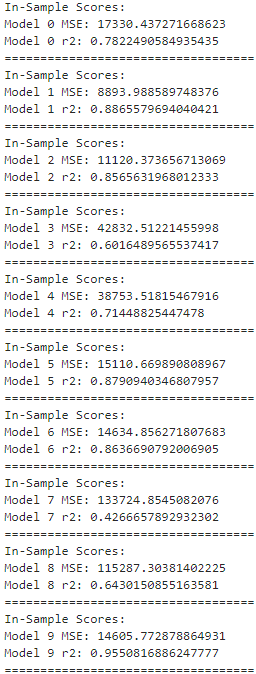

In [4]:
##################################################
# Results from training models using Census Tracts
##################################################
img = Image.open('tract_model_results.png')
display(img)

## Using Models on the Website

To use the models for price suggestion:
- We first used the 'pickle' library to save the models using the following code:
    ```python
    with open('../outputs/models_NBH.pkl', 'wb') as f:
        pickle.dump(models_NBH, f)
    ```
- Then we used ZipFile to compress and export the models to the website's input folder

Once all models are inside of the inputs folder, we can load them using the following function:
```python
def load_models(zone_type):
    if zone_type == "Neighborhoods":
        # name of the NBH models zip
        zip_filename = 'inputs/models/zip_models_NBH.zip'
        # create a zipfile object
        with zipfile.ZipFile(zip_filename, 'r') as zip_file:
            # load models from the pickle files in the zip file
            with zip_file.open('models_NBH.pkl') as f:
                models_NBH = pickle.load(f)
        return models_NBH

    else:
        # name of the tract models zip
        zip_filename = 'inputs/models/zip_models_tract.zip'
        # create a zipfile object
        with zipfile.ZipFile(zip_filename, 'r') as zip_file:
            # load models from the pickle files in the zip file
            with zip_file.open('models_tract.pkl') as f:
                models_tract = pickle.load(f)
        return models_tract
```

Finally we select a model using a dictionary we created that selects our favorite models for each month:
```python
month_to_model = {
    "April 2023": "model_0",
    "May 2023": "model_1",
    "June 2023": "model_1",
    "July 2023": "model_2",
    "August 2023": "model_2",
    "September 2023": "model_4",
    "October 2023": "model_5",
    "November 2023": "model_6",
    "December 2023": "model_6",
    "January 2024": "model_9",
    "February 2024": "model_9",
    "March 2024": "model_9",
    }

model = models[month_to_model[month_select]]
```

And output your suggested intrinsic value of the listing based on the input parameters of the survey:
```python
df = df.T.assign(**survey_columns)
st.write(f'Your Suggested List Price for {month_select} is: ${y_pred[0]:.2f}')
```